### In this tutorial, we demonstrate how to apply ALLOCATE to spatiotemporal omics data (mouse brain ageing) for cell alignment.

In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
### First, we import the functions required to run the tutorial.
import scanpy as sc
import numpy as np
from scipy.spatial import distance

from src.ALLOCATE import stALLOCATE

from src.ALLOCATE import plot_ALLOCATE_a_distribution
from src.ALLOCATE import plot_ALLOCATE_a_umap
from src.ALLOCATE import plot_ALLOCATE_a_violin

from src.ALLOCATE import get_mapping
from src.ALLOCATE import compute_temporal_growth
from src.ALLOCATE import spearman_scatter_plot

from src.ALLOCATE import aggregate_pi_by_celltype
from src.ALLOCATE import plot_ALLOCATE_transfer_heatmap
from src.ALLOCATE import pi_process
from src.ALLOCATE import compute_mapping_accuracy

In [4]:
adata = sc.read("/lustre/home/acct-clswt/clswt-jiaxinchen/ALLOCATE_backup/Data/aging.h5ad")

/lustre/home/acct-clswt/clswt-jiaxinchen/miniconda3/envs/STAligner/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


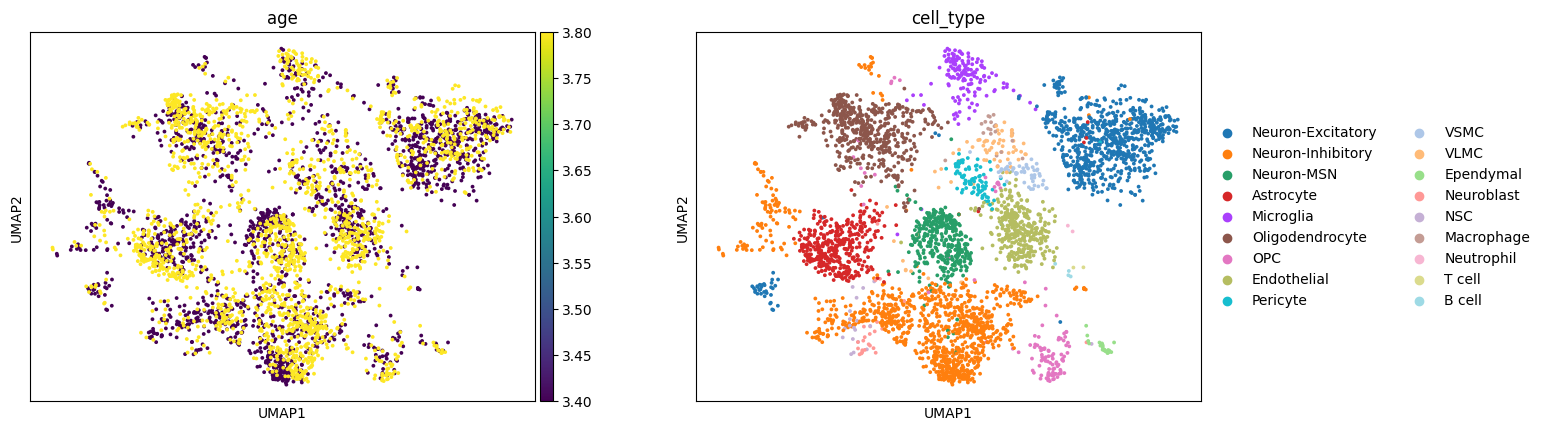

In [5]:
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20, use_rep='X_pca')
sc.pl.umap(adata, color=['age', 'cell_type'], wspace=0.2)

### Compute the cost matrix and solve the problem.

In [6]:
t1, t2 = np.sort(adata.obs["age"].unique())[:2]

adata_t1 = adata[adata.obs["age"].eq(t1)].copy()
adata_t2 = adata[adata.obs["age"].eq(t2)].copy()

X = adata_t1.obsm["X_pca"]
Y = adata_t2.obsm["X_pca"]

# Calculate expression distance
C = distance.cdist(X, Y)

C1 = distance.cdist(X, X)
C2 = distance.cdist(Y, Y)

# Calculate spatial distances
D1 = distance.cdist(adata_t1.obsm['spatial'], adata_t1.obsm['spatial'])
D2 = distance.cdist(adata_t2.obsm['spatial'], adata_t2.obsm['spatial'])

N1, N2 = C.shape[0], C.shape[1]  # 正确获取维度

# Calculate the joint cost matrix 
M1 = D1 * C1
M2 = D2 * C2

### Run stALLOCATE
The main returned value (a) represents the cell growth potential and (pi) represents the cell transition matrix.

In [7]:
a, pi, stats, a_history = stALLOCATE(
    C,
    M1,
    M2,
    alpha=0.1,
    epsilon=0.1,
    lambda_val=0.5,
    beta=0.9,
    max_outer=40,
    max_middle=100,
    max_inner=1000,
    tol=1e-4,
    sinkhorn_tol=1e-4,
)

[scALLOCATE_fusedGW] Running fused GW-OT with alpha=0.1, beta=0.9, epsilon=0.1, lambda=0.5
5.5395753338176785 11.482692136708039
10.888226398184074
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
Intermediate layer iteration 24/100
Outer layer 1/40
5.077825295363729 11.482692136708039
10.843467897140801
0
1
2
3
4
Intermediate layer iteration 5/100
Outer layer 2/40
5.120355657091232 11.482692136708039
10.848535947683052
0
1
2
3
Intermediate layer iteration 4/100
Outer layer 3/40
5.123398302092482 11.482692136708039
10.84884715168329
0
1
Intermediate layer iteration 2/100
Outer layer 4/40
5.124394866321919 11.482692136708039
10.848956240821597
0
1
Intermediate layer iteration 2/100
Outer layer 5/40
5.1250504761974796 11.482692136708039
10.84902638279982
0
1
Intermediate layer iteration 2/100
Outer layer 6/40
5.125456305305412 11.482692136708039
10.849069663196357
0
1
Intermediate layer iteration 2/100
Outer layer 7/40
5.125713534812177 11.482692136708039
10.849097028396589


ALLOCATE calculates the left marginal, and we visualize its distribution.

<Axes: title={'center': 'Marginal Distribution'}, xlabel='log10(a)', ylabel='Cell count'>

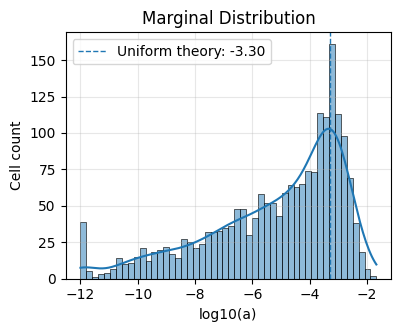

In [8]:
plot_ALLOCATE_a_distribution(
    a,
    title="Marginal Distribution",
    savepath=None,
)

ALLOCATE calculates the left marginal, and we visualize its distribution in the spatial coordinates.

/tmp/ipykernel_3317052/626559697.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_t1.obs['a_type_mean'] = adata_t1.obs.groupby('cell_type')['ot_a'].transform('mean')


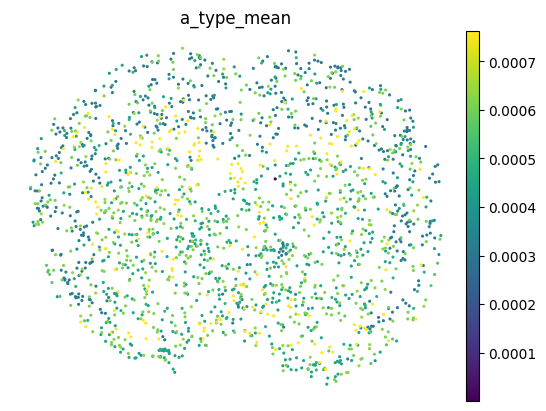

In [9]:
adata_t1.obs['ot_a'] = a

adata_t1.obs['a_type_mean'] = adata_t1.obs.groupby('cell_type')['ot_a'].transform('mean')

sc.pl.embedding(
    adata_t1,
    basis='spatial',  
    color="a_type_mean",
    frameon=False,
    size=20,  
    legend_fontsize=15
)

Display the growth potential at slice1 for individual cells and compare it across cell types.

/lustre/home/acct-clswt/clswt-jiaxinchen/ALLOCATE_backup/src/ALLOCATE/plotting.py:373: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order = adata.obs.groupby(group_key)[a_key].mean().sort_values(ascending=not descending).index.tolist()


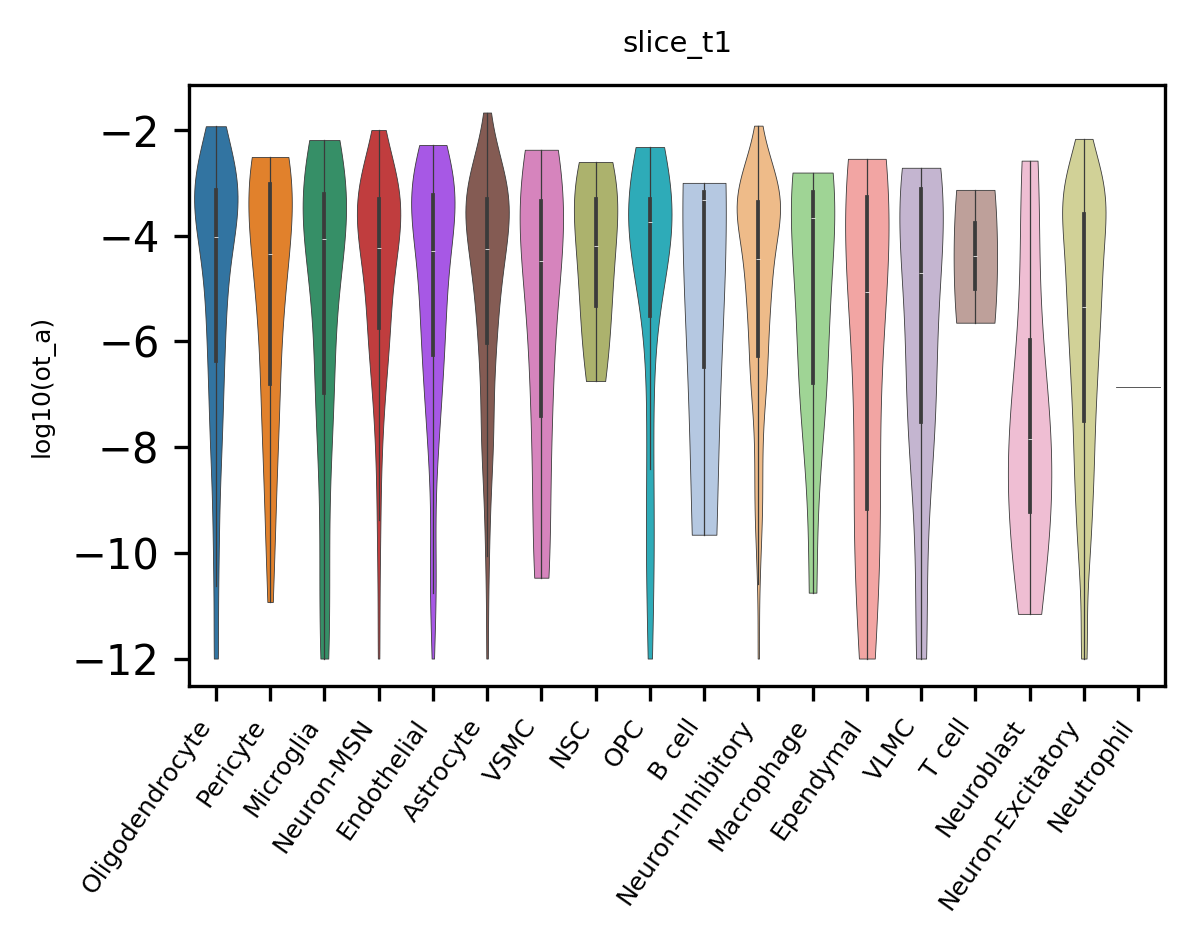

<Axes: title={'center': 'slice_t1'}, ylabel='log10(ot_a)'>

In [10]:
plot_ALLOCATE_a_violin(
    adata_t1,
    a=a,
    group_key="cell_type",
    title="slice_t1",
    savepath=None,
)

Defined and calculated the change in cell abundance between two time points using a proliferation gamma paramater, which quantifies the relative proliferation rate between two biological conditions. 

In [11]:
adapt_a = adata_t1.obs['ot_a']
adapt_a_means = adapt_a.groupby(adata_t1.obs['cell_type']).mean().reset_index(name='a_means')

pi_matrix = pi
t1 = adata_t1
t2 = adata_t2
celltype='cell_type'

parent_mapping, type_transfer = get_mapping(pi_matrix, t1, t2, celltype_col="cell_type")
gamma_df = compute_temporal_growth(
    early_obs=t1.obs,
    late_obs=t2.obs,
    celltype_col="cell_type",
    subtype_parent_map=parent_mapping,
)
gamma_df

/tmp/ipykernel_3317052/1124631423.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adapt_a_means = adapt_a.groupby(adata_t1.obs['cell_type']).mean().reset_index(name='a_means')


,cell_type,gamma
0,Endothelial,0.248366
1,Neuron-Excitatory,-0.371134
2,Oligodendrocyte,0.492754
3,Neuron-Inhibitory,-0.102041
4,VSMC,-0.250000
5,Microglia,0.220588
6,Astrocyte,0.174863
7,Neuron-MSN,0.120000
8,OPC,0.240000
9,Neuroblast,-0.285714


Computed the Spearman correlation between the gamma and the learned marginal a. 

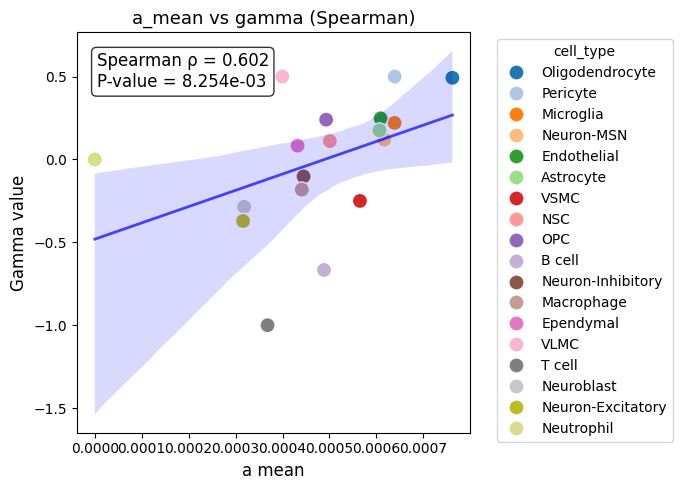

In [12]:
spearman_r, spearman_p, fig = spearman_scatter_plot(
    a_means_df=adapt_a_means,
    gamma_df=gamma_df,
    x_col="a_means",
    y_col="gamma",
    hue_col="cell_type",
    title="a_mean vs gamma (Spearman)",
)

The method accurately aligned cells across time points, with the cell-type alignment matrix exhibiting a clear diagonal structure.
The vertical axis of the heatmap represents the previous time point, while the horizontal axis represents the subsequent time point.

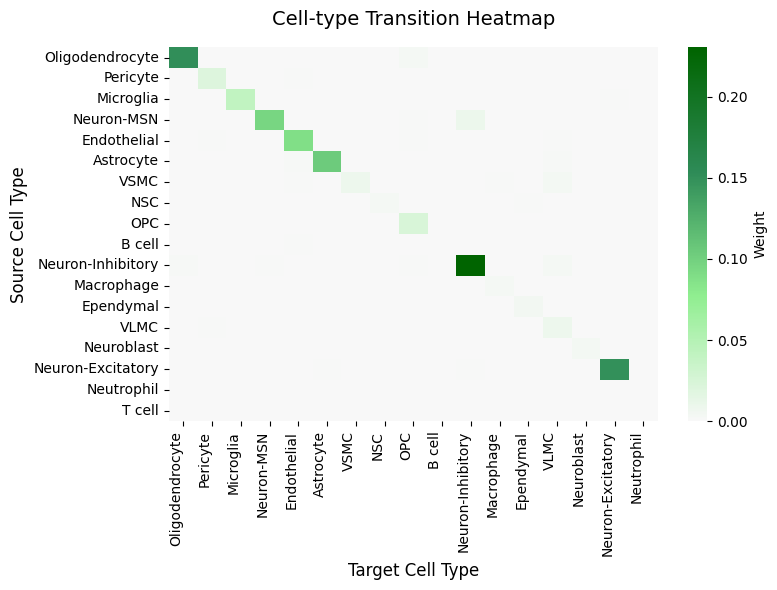

<Axes: title={'center': 'Cell-type Transition Heatmap'}, xlabel='Target Cell Type', ylabel='Source Cell Type'>

In [13]:
transfer_df = aggregate_pi_by_celltype(adata_t1, adata_t2, pi, celltype_key="cell_type")

plot_ALLOCATE_transfer_heatmap(
    transfer_df,
    title="Cell-type Transition Heatmap",
    savepath="adapt_pi_heatmap.pdf",
)

Finally, we calculated the cell-type mapping accuracy across two developmental stage pairs.

In [14]:
flow_df = pi_process(adata_t1,adata_t2,pi, key = 'cell_type')
compute_mapping_accuracy(flow_df,source_col= "source",target_col= "target",weight_col= "weight")

0.936897341273208